### Prepare data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape, mapping, LineString, MultiLineString
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt
import mplleaflet
from geopandas import GeoDataFrame
import geopandas as gpd
from collections import Counter
import glob
from pygeoif import geometry
import libpysal

In [2]:
crs = {'init': 'epsg:4326'}
cea = {'proj':'cea'}
amersfoort = {'init': 'epsg:28992'}
mercator = {'init': '3395'}

In [3]:
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 100)

Import all data

In [4]:
df_buurt = pd.read_csv("Data/buurt.csv", sep=";")

In [5]:
df_grond = pd.read_csv("Data/grond.csv", sep=";")
df_boom = pd.concat([pd.read_csv(file, dtype=str, sep=';') for file in glob.glob('Data/boom*')], 
                    axis=0, ignore_index=True).rename(columns={'OBJECTNUMMER': 'obj_nr'})
df_plan = pd.read_csv("Data/plan.csv", sep=";")
df_strat = pd.read_csv("Data/strat.csv", sep=';')

Set the coordinates for the GeoDataFrames. We make MultiPolygons instead of regular Polygons, because some of the rows contain MultiPolygons and ignoring them results in strange area display.

In [6]:
grond_geom = gpd.GeoSeries(df_grond.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
buurt_geom = gpd.GeoSeries(df_buurt.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
boom_geom = gpd.GeoSeries(df_boom.WKT_LNG_LAT.str.replace(",", " ").apply(wkt.loads))
plan_geom = gpd.GeoSeries(df_plan.WKT_LNG_LAT.apply(wkt.loads).apply(lambda x: MultiPolygon([x])))
strat_geom = gpd.GeoSeries(df_strat.WKT_LNG_LAT.apply(lambda x: geometry.from_wkt(x)).apply(lambda g: shape(g)))

In [7]:
gdf_grond = GeoDataFrame(df_grond, geometry=grond_geom).reset_index()
gdf_buurt = GeoDataFrame(df_buurt, geometry=buurt_geom).reset_index()
gdf_boom = GeoDataFrame(df_boom, geometry=boom_geom).reset_index()
gdf_plan = GeoDataFrame(df_plan, geometry=plan_geom).reset_index()
gdf_strat = GeoDataFrame(df_strat, geometry=strat_geom).reset_index()

### Buurt

Include counter of amount of trees per area

In [8]:
df_temp = gpd.sjoin(gdf_buurt, gdf_boom, how='left', op='contains').groupby("Buurt").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'Buurt'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_buurt = gdf_buurt.merge(df_temp, on=["Buurt"])
del df_temp

Tree Index

In [9]:
gdf_buurt["aantal_bomen_m2"] = gdf_buurt.aantal_bomen / gdf_buurt.Opp_m2
gdf_buurt["aantal_bomen_index"] = gdf_buurt.aantal_bomen_m2 / gdf_buurt.aantal_bomen_m2.max() 

Define Amsterdam: All areas except for 'Stadsdeel N'

In [10]:
Amsterdam = gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].geometry.unary_union

### Terrains

Trees per terrain

In [11]:
df_temp = gpd.sjoin(gdf_grond, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_grond = gdf_grond.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

In [12]:
gdf_grond["aantal_bomen_m2"] = gdf_grond.aantal_bomen / gdf_grond.Oppervlakte_m2
gdf_grond["aantal_bomen_index"] = gdf_grond.aantal_bomen_m2 / gdf_grond.aantal_bomen_m2.max() 

Define terrains suitable for planting clusters of trees

In [13]:
list(gdf_grond.AMScode_Oms.unique())

['Spoorterrein',
 'Metro,  vrije trambanen',
 'Bedrijfsspoor',
 'Wegverkeersterrein',
 'Wegverkeersterrein rijkswegen',
 'Wegverkeersterrein provinciale wegen',
 'Vliegveld (NIET het gras!!)',
 'Woonterrein',
 'Detailhandel, winkelcentra en horeca',
 'Overheid (kantoor/dienstverlening/openbare voorzieningen)',
 'Overheid (nutsbedrijven/defensieterrein)',
 'Sociaal-culturele voorzieningen (incl. onderwijs, gezondheidszorg)',
 'Bedrijventerrein (industrie, tentoonstellingsterrein, garagebedrijven)',
 'Bedrijventerrein (overwegend kantoren/kantoorachtig)',
 'Stortplaats',
 'Wrakkenopslagplaats',
 'Begraafplaats',
 'Bouwterrein woonbestemming',
 'Bouwterrein niet-woon bestemming',
 'Tijdelijke opslag van grond',
 'Semi verhard overig terrein',
 'Park en plantsoen',
 'Sportterrein',
 'Golfterrein',
 'Parkeerterrein ArenA',
 'Volkstuin',
 'Dagrecreatief terrein',
 'Artis',
 'Verblijfsrecreatief terrein',
 'Terrein voor glastuinbouw',
 'Overig agrarisch terrein',
 'Bos',
 'Open droog-natuurli

In [14]:
terrains = ["Bouwterrein woonbestemming", "Bouwterrein niet-woon bestemming", 
            "Tijdelijke opslag van grond", "Semi-verhard overig terrein"]
terrein = list(gdf_grond.CBScode1_Oms.unique())

Select only those terrains that are within Amsterdam

In [15]:
gdf_grond["InBuurt"] = gdf_grond.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

In [16]:
gdf_temp = gdf_grond[gdf_grond.AMScode_Oms.isin(terrains)]
gdf_grond_in_buurt = gdf_temp[gdf_grond.InBuurt.isin([True])]
gdf_grond_in_buurt["aantal_bomen_index"] = gdf_grond_in_buurt.aantal_bomen_m2 / gdf_grond_in_buurt.aantal_bomen_m2.max()
del gdf_temp

C:\Users\TSmeitink\Anaconda3\lib\site-packages\geopandas\geodataframe.py:455: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)
C:\Users\TSmeitink\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Housing plans

Trees per plan

In [17]:
df_temp = gpd.sjoin(gdf_strat, gdf_boom, how='left', op='contains').groupby("OBJECTNUMMER").count().\
    Boomtype.reset_index().\
    rename(columns={'index': 'OBJECTNUMMER'}).\
    rename(columns={'Boomtype': 'aantal_bomen'})
gdf_strat = gdf_strat.merge(df_temp, on=["OBJECTNUMMER"])
del df_temp

Tree Index

In [18]:
gdf_strat["area"] = gdf_strat.geometry.apply(lambda x: x.area)

In [19]:
gdf_strat["aantal_bomen_area"] = gdf_strat.aantal_bomen / gdf_strat.area
gdf_strat["aantal_bomen_index"] = gdf_strat.aantal_bomen_area / gdf_strat.area.max() 

In [20]:
gdf_strat["InBuurt"] = gdf_strat.geometry.apply(lambda x: True if Amsterdam.contains(x) else False)

In [21]:
gdf_strat_in_buurt = gdf_strat[gdf_strat.InBuurt.isin([True])]

### Visualisation

C:\Users\TSmeitink\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


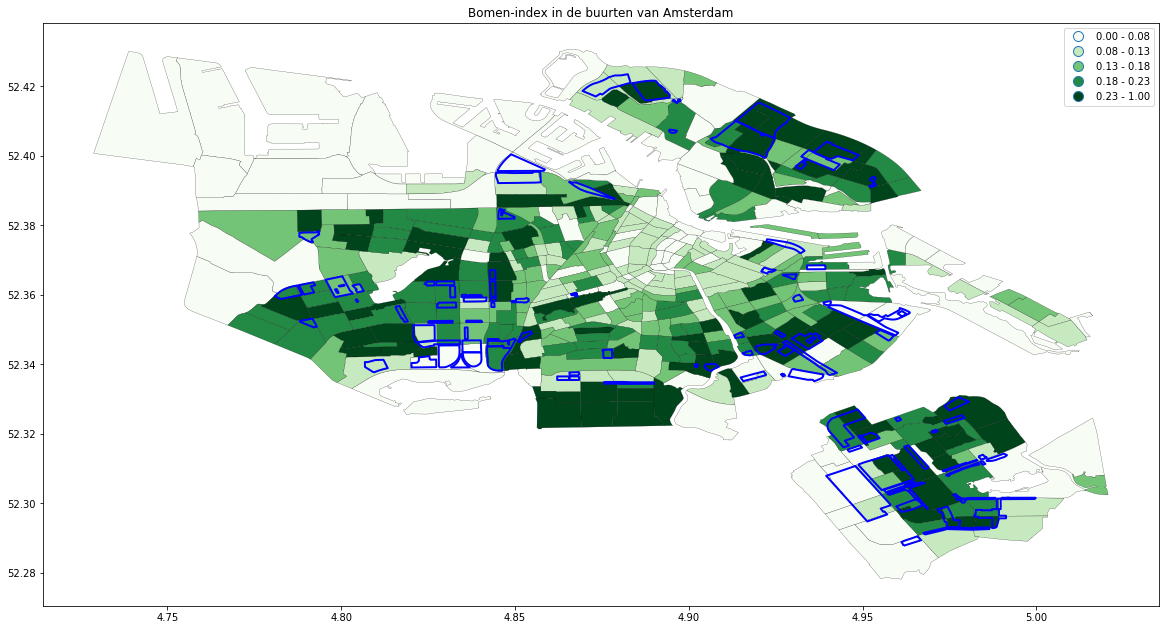

In [22]:
fig, ax = plt.subplots(figsize=(20, 20))
plt.title("Bomen-index in de buurten van Amsterdam")
gdf_buurt[gdf_buurt.Buurtcombinatie_code != 'N73'].\
    plot(ax=ax, column='aantal_bomen_index', edgecolor='black', linewidth=0.2, cmap='Greens', scheme='quantiles', legend=True)
# gdf_strat[gdf_buurt.Buurtcombinatie_code != 'N73'].plot(ax=ax, alpha=1, edgecolor='blue', linewidth=2, facecolor="none")
gdf_strat_in_buurt.plot(ax=ax, alpha=1, edgecolor='blue', linewidth=2, facecolor="none")
leg = ax.get_legend()
# leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
leg
# mplleaflet.show(fig=ax.figure, tiles="cartodb_positron")
plt.show();